# Time-Series Forecasting

ARIMA model for FB closing prices

* Pull data from Google Cloud Storage into a Pandas dataframe
* Prepare raw stock closing data for an ARIMA model
* Apply Dickey-Fuller test 
* Build an ARIMA model using the statsmodels library

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import datetime

%config InlineBackend.figure_format = 'retina'

## Import data from Google Cloud Storage

Load ten years' worth of FB stock data into a dataframe. 
Set the date as the index. 

In [3]:
df = pd.read_csv('FB_10y.csv')

In [6]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-05-18,42.049999,45.000000,38.000000,38.230000,38.230000,573576400
1,2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
2,2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
3,2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
4,2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999,50237200


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2315 entries, 0 to 2314
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2315 non-null   object 
 1   Open       2315 non-null   float64
 2   High       2315 non-null   float64
 3   Low        2315 non-null   float64
 4   Close      2315 non-null   float64
 5   Adj Close  2315 non-null   float64
 6   Volume     2315 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 126.7+ KB


In [10]:
# Convert date column to a Datetime
df['Date'] = pd.to_datetime(df['Date'])

### Set the `'Date'` column as the index:

In [11]:
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)

print(df.shape)

df.head()

(2315, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-05-18,42.049999,45.000000,38.000000,38.230000,38.230000,573576400
2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999,50237200


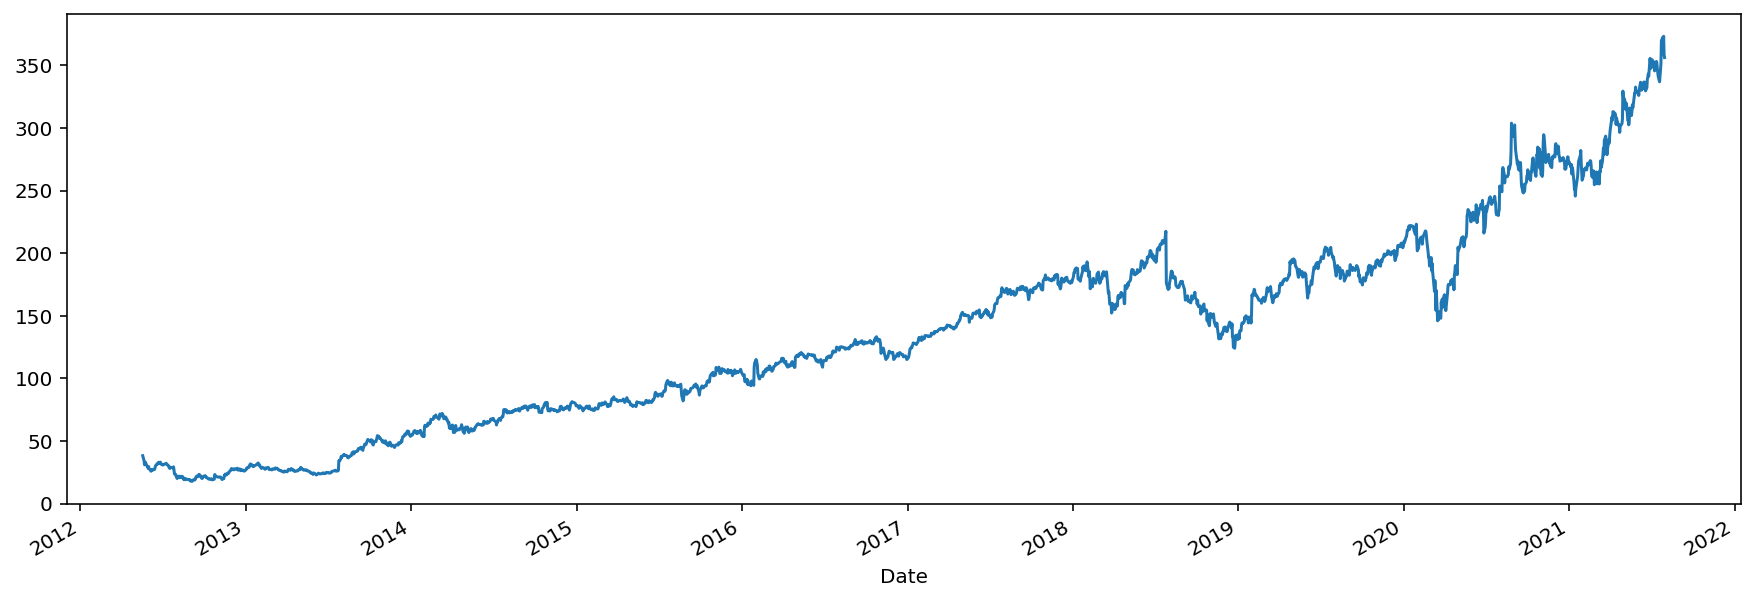

In [12]:
plt.figure(figsize=(15,5))
df['Close'].plot();

## Prepare data for ARIMA 

### Create a column for the weekly returns
- Resample the data using `.resample('w')`
    - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html
- You add an aggregation method onto `.resample()` that tells it if you want to take the `.sum()` or `.mean()` or `.max()` of each week's values. 
- Use `.mean()` to take the weekly mean `'Close'` value
- Then, we'll just subset the data to the 'Close' column for each week

In [13]:
df_week = df.resample('w').mean()
df_week = df_week[['Close']]
df_week.head()

,Close
Date,
2012-05-20,38.2300
2012-05-27,32.3940
2012-06-03,28.5875
2012-06-10,26.5980
2012-06-17,27.9960


## Plot the weekly returns and take notice of the value change over time:
- Over time, the value changes quite dramatically from < 50 to 300
- Take the log of the weekly return to adjust for the wide spread of values

<Figure size 1080x360 with 0 Axes>

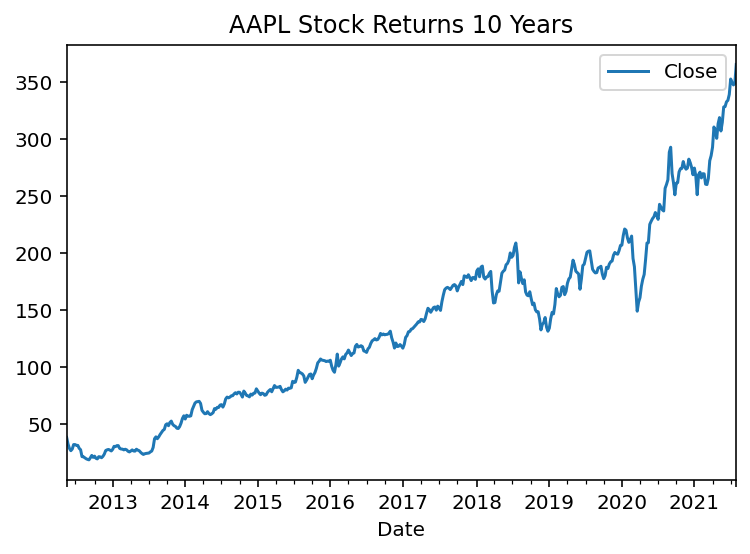

In [16]:
plt.figure(figsize=(15,5))
df_week.plot()
plt.title('FB Stock Returns 10 Years');


### Take the difference between lagged values using `.diff()` and plot the resulting series
- Question: What, if any, are the parameters of .diff()?
- Answer: periods to shift (default= 1), axis to difference on (default =0 for rows)
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.diff.html

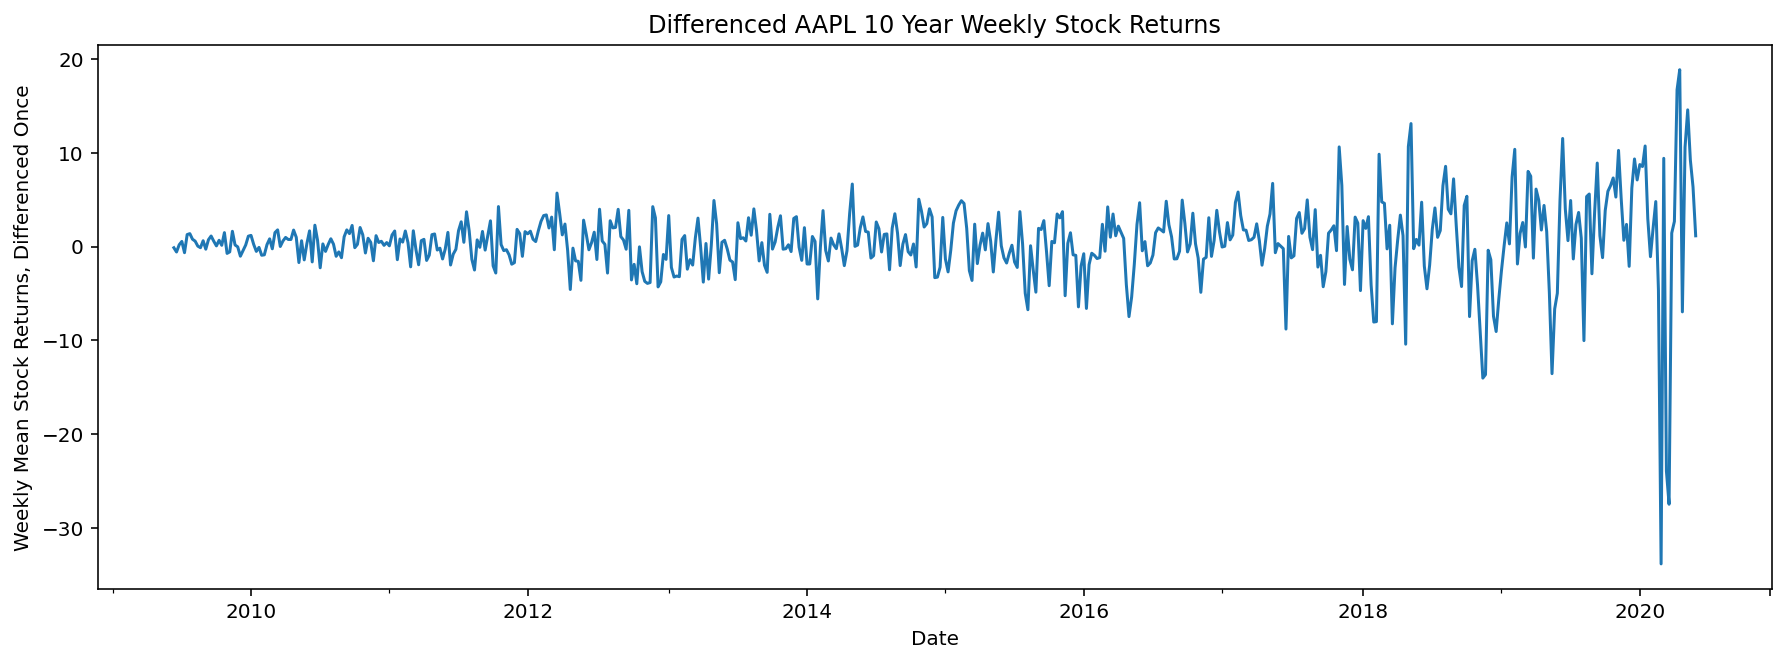

In [11]:
plt.figure(figsize=(15,5))
df_week['Close'].diff().plot()
plt.title('Differenced FB 10 Year Weekly Stock Returns')
plt.ylabel('Weekly Mean Stock Returns, Differenced Once');


- Often, the 'difference' is called the `'return'`
- When you don't take a difference, you are at `'level'`
---
### Let's also take the log of the result, which minimizes the distance when there are large differences in values.
- Save the resulting differenced-logged column as `'Weekly_ret'`

In [12]:
df_week['Weekly_ret'] = np.log(df_week['Close']).diff()
df_week.head()

,Close,Weekly_ret
Date,,
2009-06-07,20.234286,NaN
2009-06-14,20.106857,-0.006318
2009-06-21,19.525143,-0.029358
2009-06-28,19.711429,0.009496
2009-07-05,20.258928,0.027397


Drop the null rows that are the first rows, since there is nothing to difference it with.

In [13]:
# drop null rows
df_week.dropna(inplace=True)

Plot the data as a time -series

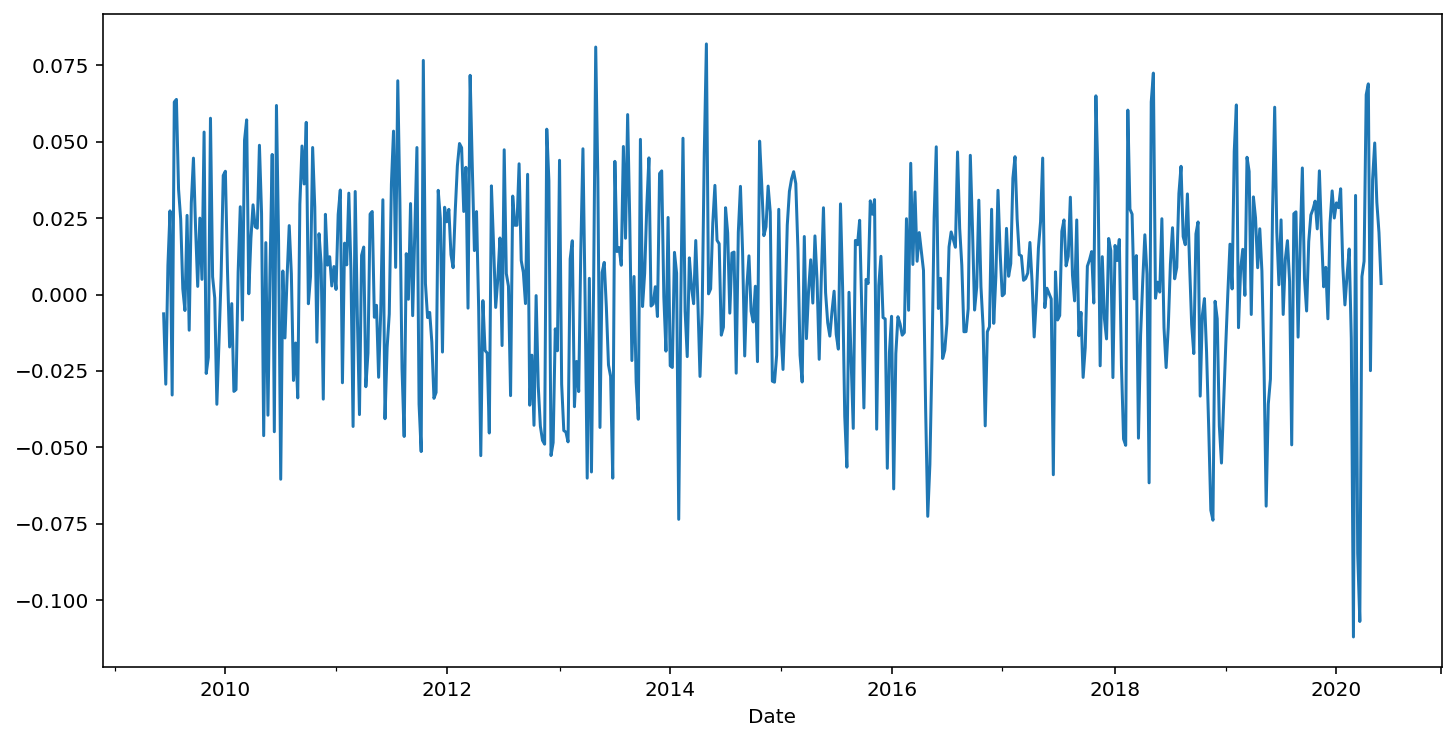

In [14]:
df_week.Weekly_ret.plot(kind='line', figsize=(12, 6));

### Let's focus on the `'Weekly_ret'` column:
- We can drop the close column because we only care about the difference now.

In [15]:
df_week = df_week.drop(['Close'], axis=1)
df_week.head()

,Weekly_ret
Date,
2009-06-14,-0.006318
2009-06-21,-0.029358
2009-06-28,0.009496
2009-07-05,0.027397
2009-07-12,-0.032906


## Dickey-Fuller Test for stationarity of the `df_week` series

- Time series are stationary if they do not contain trends or seasonal swings. 
- The Dickey-Fuller test can be used to test for stationarity. 

In [16]:
import statsmodels.api as sm
# This required that I go back to scipy-1.2.0 via pip install scipy==1.2
# Pandas must also be 0.23.2 pip install pandas==0.23.2
# Don't love this fact, but okay.

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [17]:
from statsmodels.tsa.stattools import adfuller

In [18]:
# Calculate a rolling std dev and average based on a 20-value window
rolling_mean = df_week.rolling(20).mean()
rolling_std = df_week.rolling(20).std()

Plot MA against difference time series.
- Difference is centered around zero with some fluctuations.

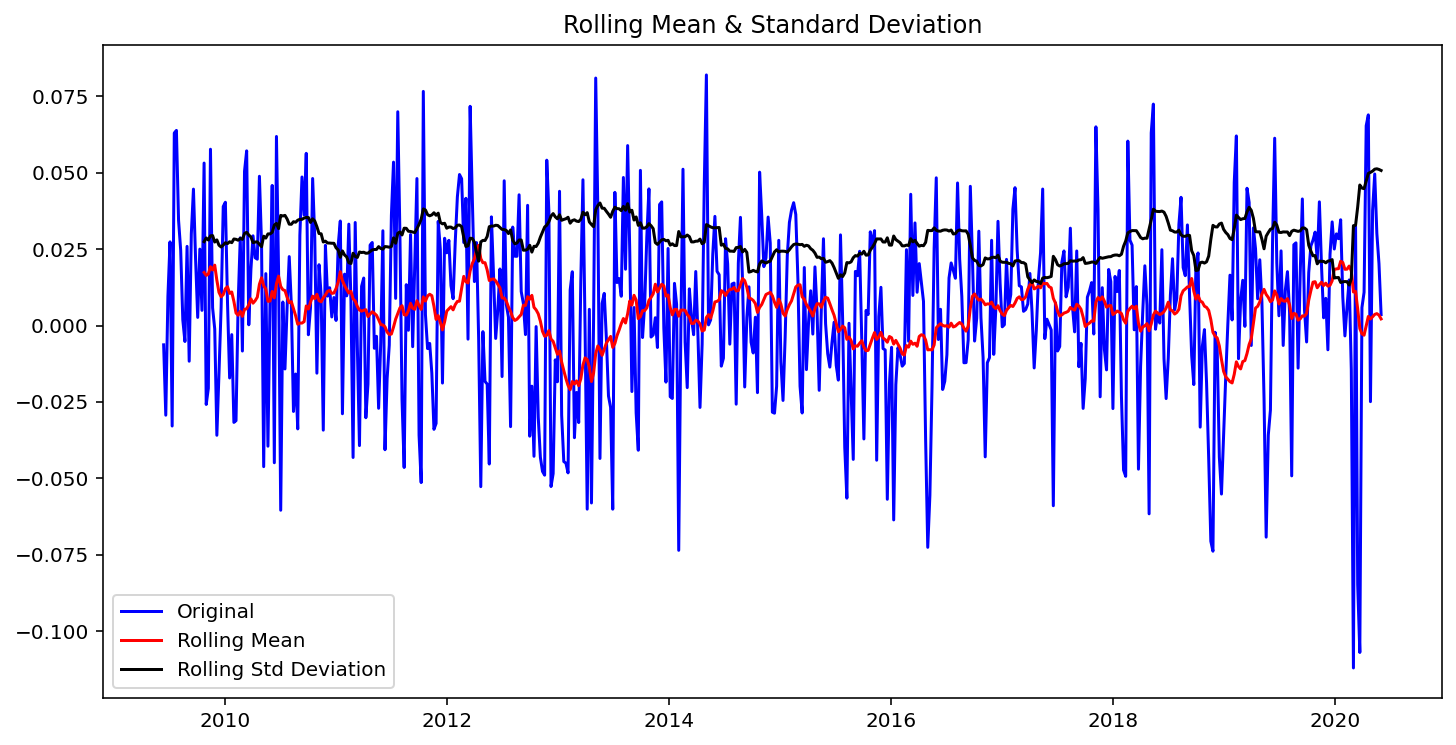

In [19]:
plt.figure(figsize=(12, 6))
# Create 3 series for the time-series, the mean, and the std deve
orig = plt.plot(df_week, color='blue', label='Original')
mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
std = plt.plot(rolling_std, color='black', label = 'Rolling Std Deviation')

plt.title('Rolling Mean & Standard Deviation')
plt.legend(loc='best')
plt.show(block=False)

# Does the rolling mean look stationary?
- Look at 10/ 30 / 25 rolling mean

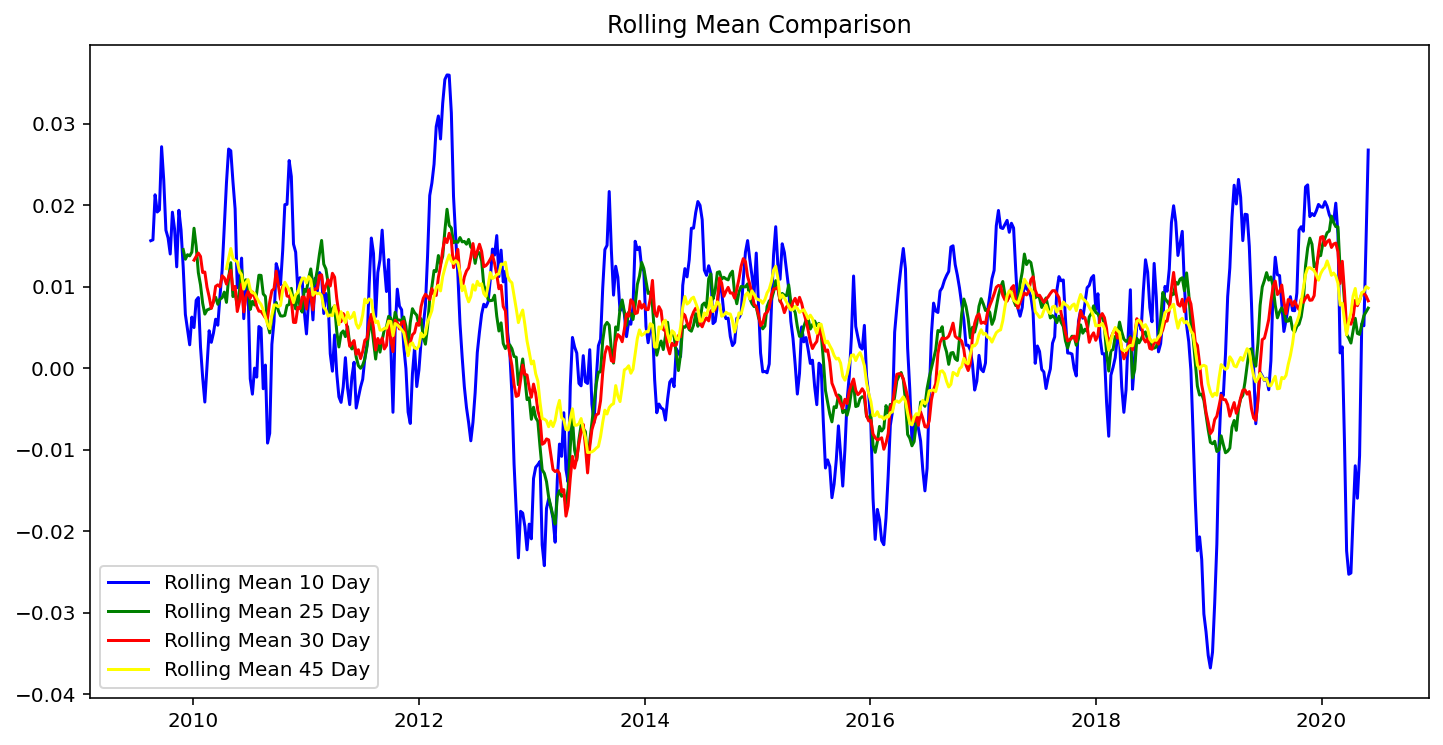

In [20]:
plt.figure(figsize=(12, 6))
mean_10 = plt.plot(df_week.rolling(10).mean(), color='blue', label='Rolling Mean 10 Day')
mean_25 = plt.plot(df_week.rolling(25).mean(), color='green', label='Rolling Mean 25 Day')
mean_30 = plt.plot(df_week.rolling(30).mean(), color='red', label='Rolling Mean 30 Day')
mean_45 = plt.plot(df_week.rolling(45).mean(), color='yellow', label='Rolling Mean 45 Day')
plt.title('Rolling Mean Comparison')
plt.legend(loc='best')
plt.show(block=False)

## We can actually apply DF test
- https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
- `"The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation."`
- The DF test null hypothesis is that the series exhibits non-stationarity.
    - Xt = alpha + rho * Xt-1 + errort
    - Null hypothesis H0: rho = 1
    - H1: rho < 1
- Unit root tests are similar to serial correlation tests. 
    - Caveat all processes with a unit root will have serial correlation, but not all serially correlated time series will have a unit root. P
    
- Common serial correlation tests you might have heard of include:
    - Breusch–Godfrey test
    - Ljung–Box test
    - Durbin–Watson test


In [21]:
# Perform Dickey-Fuller test
dftest = sm.tsa.adfuller(df_week.Weekly_ret, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value ({0})'.format(key)] = value
    
dfoutput

Test Statistic                -1.146776e+01
p-value                        5.359001e-21
#Lags Used                     2.000000e+00
Number of Observations Used    5.700000e+02
Critical Value (1%)           -3.441875e+00
Critical Value (5%)           -2.866624e+00
Critical Value (10%)          -2.569478e+00
dtype: float64

With a p-value < 0.05, we can reject the null hypothesis. This data set is stationary.

## ACF and PACF Charts

Making autocorrelation and partial autocorrelation charts help us choose hyperparameters for the ARIMA model.

The ACF gives us a measure of how much each "y" value is correlated to the previous n "y" values prior.

The PACF is the partial correlation function gives us (a sample of) the amount of correlation between two "y" values separated by n lags excluding the impact of all the "y" values in between them. 

In [22]:
from statsmodels.graphics.tsaplots import plot_acf

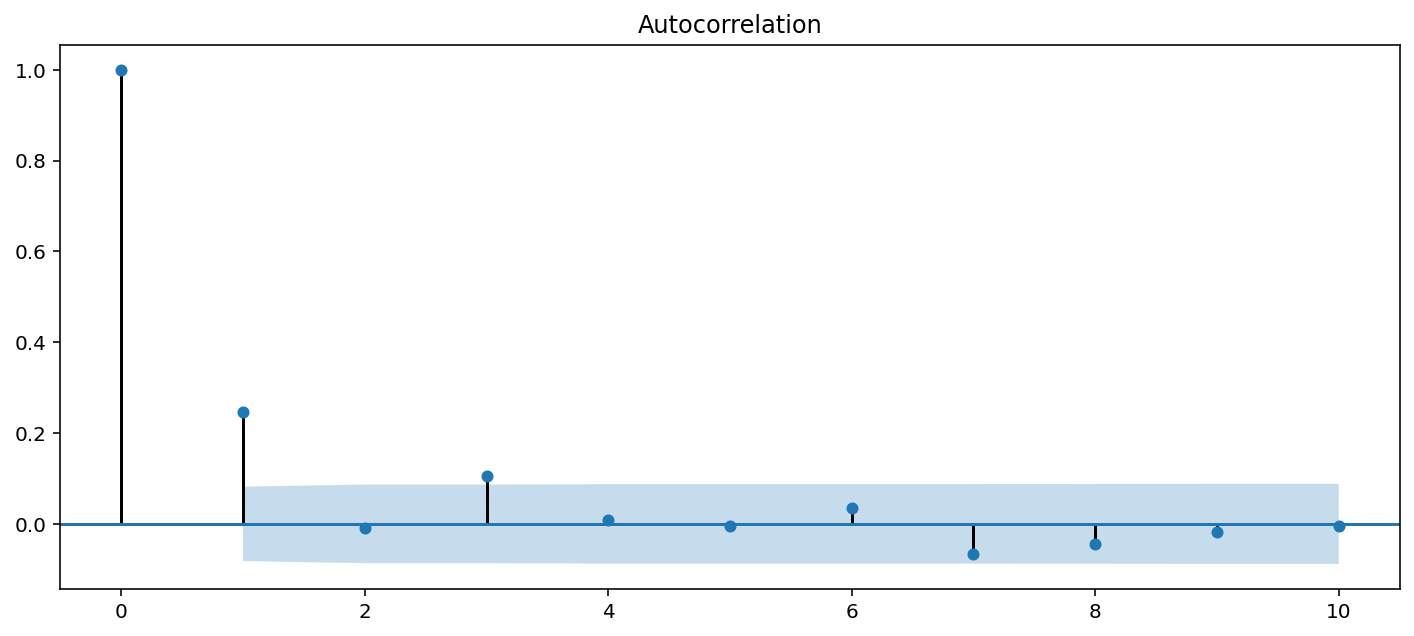

In [23]:
# the autocorrelation chart provides just the correlation at increasing lags
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(df_week.values, lags=10, ax=ax)
plt.show()

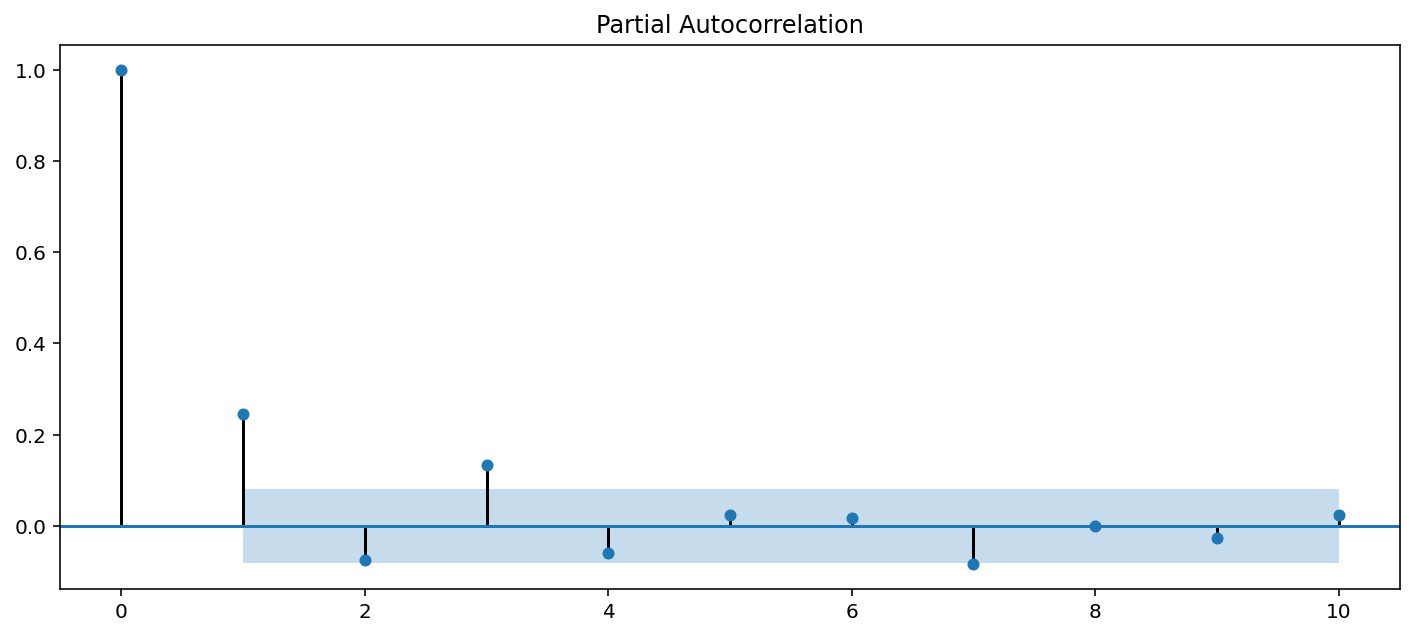

In [24]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(df_week.values, lags=10, ax=ax)
plt.show()

For ARMA model, we want to pick the lags corresponding to points outside of the blue shaded areas. 
- ARMA autocorrlaation plot we can choose 1.
- PAF we can choose 1 or 3 for hhyperparameter 3.

## Build ARIMA Model

Since we differenced the weekly closing prices, we technically only need to build an ARMA model. The data has already been integrated and is stationary. 
- We just looked at the ACF and PACF to determine p = 2, q = 3

### The more negative the AIC, the better

In [25]:
df_week.head()

,Weekly_ret
Date,
2009-06-14,-0.006318
2009-06-21,-0.029358
2009-06-28,0.009496
2009-07-05,0.027397
2009-07-12,-0.032906


https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARMA.html

In [26]:
from statsmodels.tsa.arima_model import ARMA

# Notice that you have to use udiff - the differenced data (stationary) rather than the original data. 
ar1 = ARMA(tuple(df_week.values), (2,3)).fit()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  573
Model:                     ARMA(2, 3)   Log Likelihood                1228.805
Method:                       css-mle   S.D. of innovations              0.028
Date:                Wed, 24 Jun 2020   AIC                          -2443.610
Time:                        21:19:46   BIC                          -2413.154
Sample:                             0   HQIC                         -2431.730
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.002      2.962      0.003       0.002       0.008
ar.L1.y        0.3007      0.488      0.616      0.538      -0.656       1.258
ar.L2.y       -0.0708      0.231     -0.306      0.760      -0.524       0.383
ma.L1.y       -0.0216      0.485     -0.044      0.965      -0.972       0.929
ma.L2.y       -0.0485      0.277     -0.175      0.861      -0.592       0.495
ma.L3.y        0.1254      0.077      1.622      0.105      -0.026       0.277
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.1249           -3.1014j            3.7595           -0.1544
AR.2            2.1249           +3.1014j            3.7595            0.1544
MA.1           -1.9037           -0.0000j            1.9037           -0.5000
MA.2            1.1453           -1.6961j            2.0466           -0.1555
MA.3            1.1453           +1.6961j            2.0466            0.1555
-----------------------------------------------------------------------------
"""

Our model doesn't do a good job predicting variance in the original data (peaks and valleys), but does a good job predicting direction.

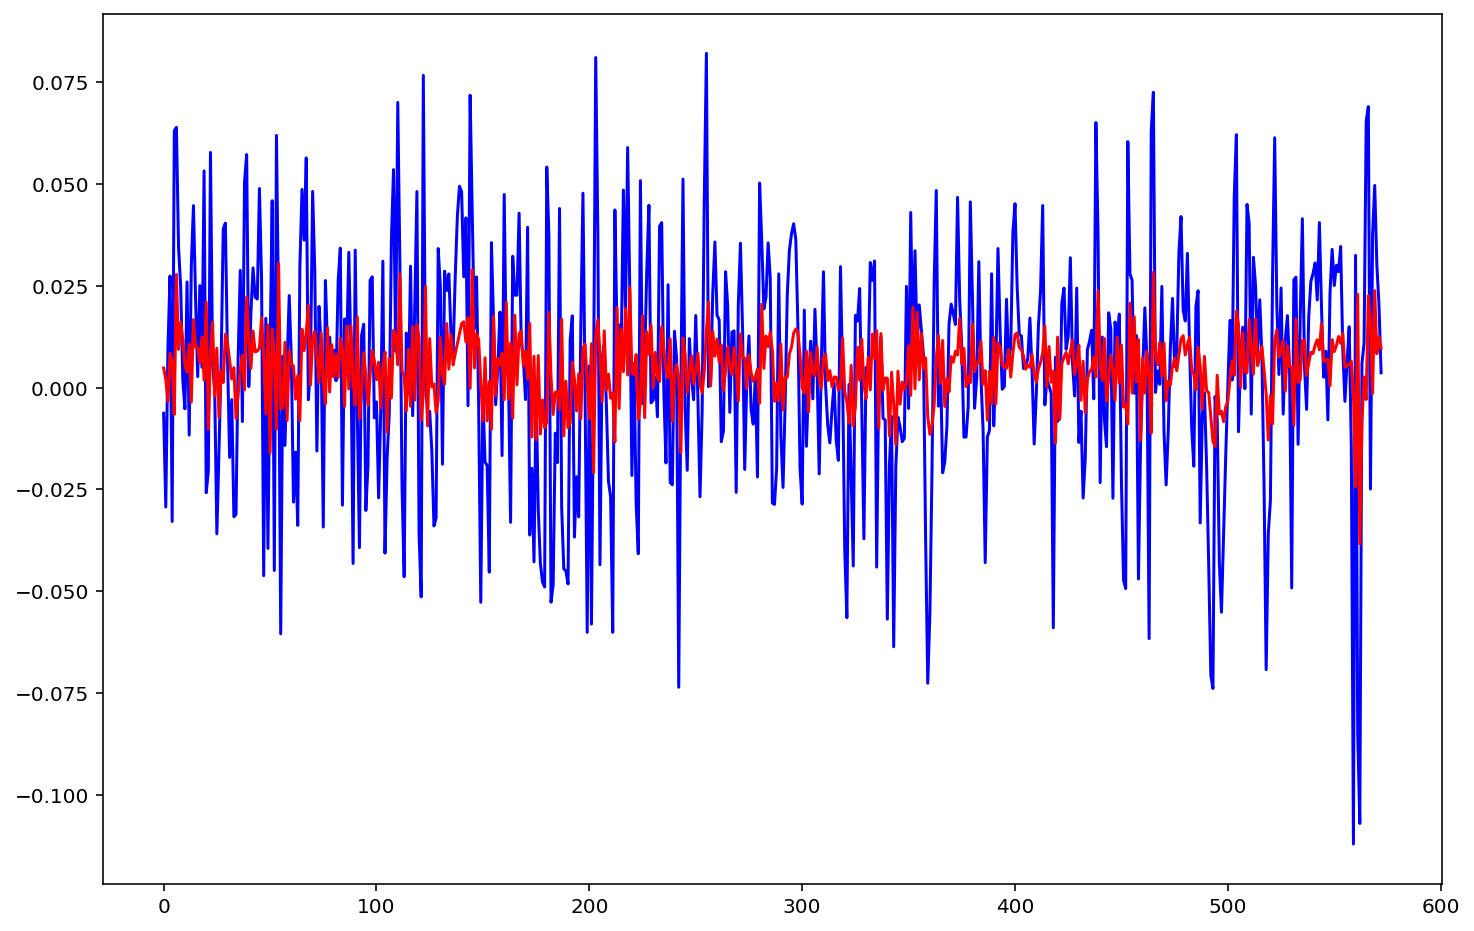

In [27]:
plt.figure(figsize=(12, 8))
plt.plot(df_week.values, color='blue')
preds = ar1.fittedvalues
plt.plot(preds, color='red')
plt.show()

Let's make a forecast 2 weeks ahead:

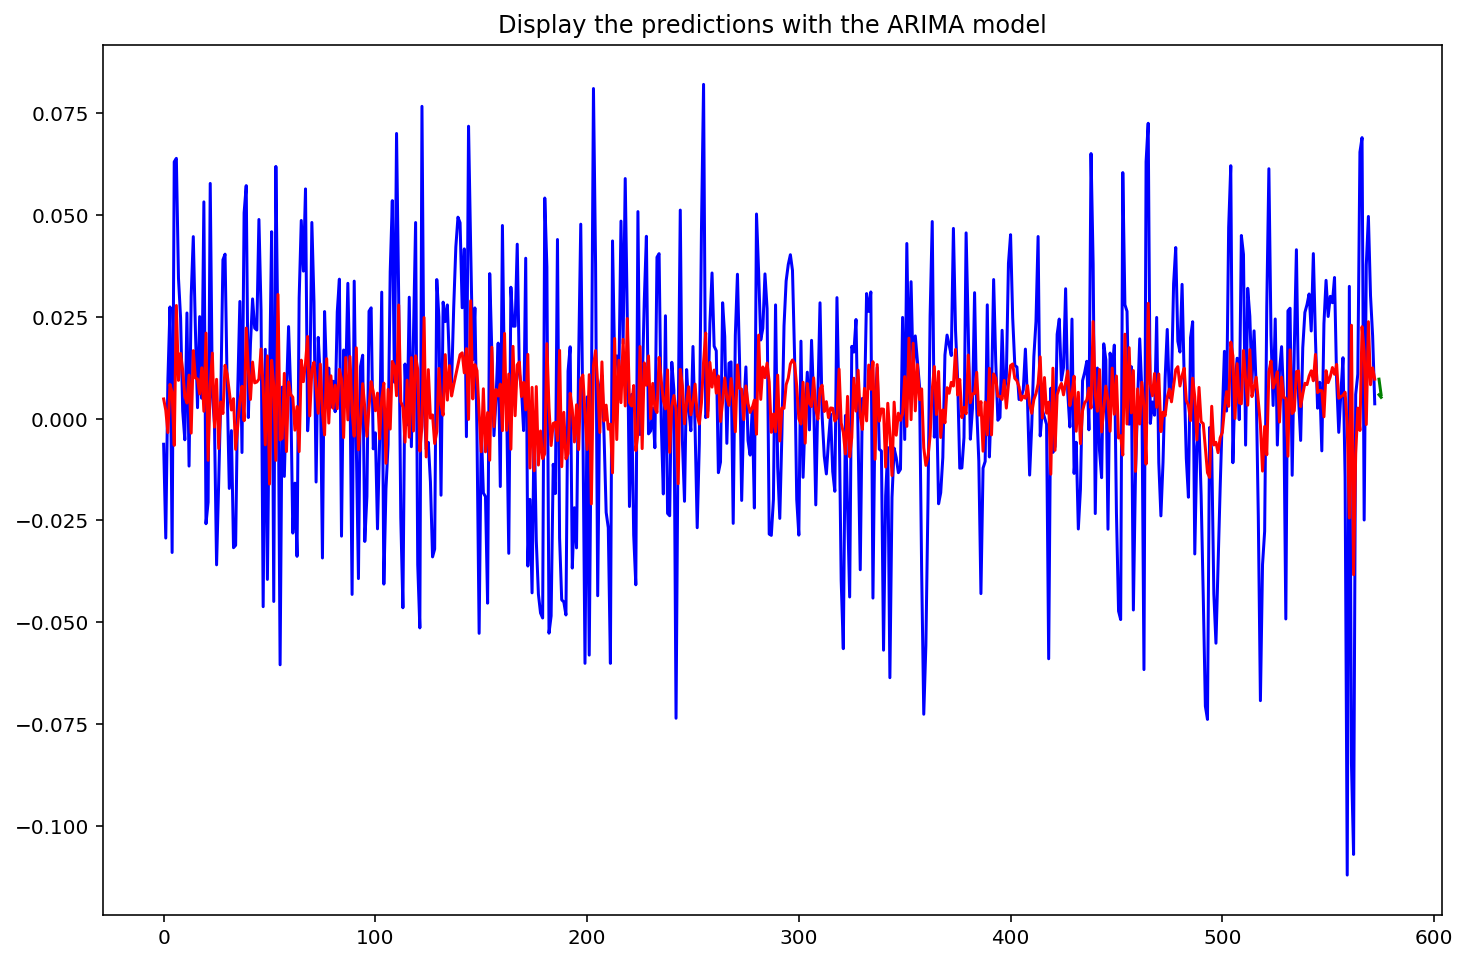

In [28]:
steps = 2 # number of weeks

forecast = ar1.forecast(steps=steps)[0]

plt.figure(figsize=(12, 8))
plt.plot(df_week.values, color='blue')

preds = ar1.fittedvalues
plt.plot(preds, color='red')

plt.plot(pd.DataFrame(np.array([preds[-1],forecast[0]]).T,
                      index=range(len(df_week.values)+1, 
                                  len(df_week.values)+3)), 
         color='green')

plt.plot(pd.DataFrame(forecast,
                      index=range(len(df_week.values)+1, 
                                  len(df_week.values)+1+steps)), 
         color='green')
plt.title('Display the predictions with the ARIMA model')
plt.show()

The forecast is not great but if you tune the hyper parameters some more, you might be able to reduce the errors.
### Change the differencing to do a second difference and re-run the model with new parameters chosen from the plots:
`df_week['Weekly_ret'] = np.log(df_week['Close']).diff(2)`
- Change the ARMA model parameters to (3,0) and rerun the plots and forecast. Better?
    - `ar1 = ARMA(tuple(df_week.values), (3,0)).fit()`